# China Projects: Food waste treatment and co-digestion

In [241]:
library(Benchmarking)
library(ggplot2)
library(tidyverse)
library(GGally)
library(mice)
library(VIM)
library(reshape2)
library(gridExtra)
library(missForest)
library(rpart)
library(randomForest)
library(caret)

## 1. Data preparation, imputation, and vizualization

#### Data cleaning and imputation

In [42]:
# Read in data
df <- read.csv("DataDEA2.csv")

In [242]:
# Change variable types (numeric or factor)
df$Total_Investment_RMB <- as.numeric(df$Total_Investment_RMB)
df$Total_Input_t.d <- as.numeric(df$Total_Input_t.d)
df$DigestedWaste <- as.factor(df$DigestedWaste)
df$Codigestion. <- as.factor(df$Codigestion.)
df$RawBiogas_m3.d <- as.numeric(df$RawBiogas_m3.d)
df$All.outputs..inc.biogas <- as.factor(df$All.outputs..inc.biogas)
df$Biogas.upgrading. <- as.factor(df$Biogas.upgrading.)
df$Pretreatment <- as.factor(df$Pretreatment)

In [243]:
# Keep relevant variables in a new data frame
df2 <- df[c('Total_Investment_RMB','Total_Input_t.d',
                 'DigestedWaste','Codigestion.',
                'RawBiogas_m3.d', 'All.outputs..inc.biogas')]


 Variables sorted by number of missings: 
                Variable      Count
          RawBiogas_m3.d 0.43564356
 All.outputs..inc.biogas 0.25742574
    Total_Investment_RMB 0.02970297
         Total_Input_t.d 0.00000000
           DigestedWaste 0.00000000
            Codigestion. 0.00000000


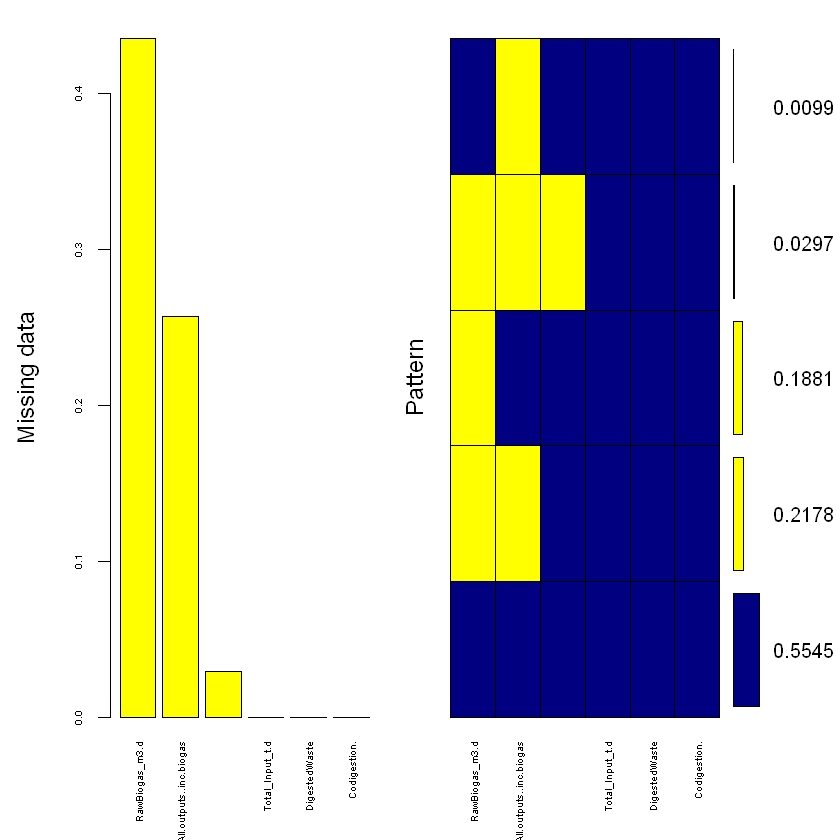

In [244]:
# Test for missing values and visualize  
missVals_plot <- aggr(df_pairs, col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(df_pairs), cex.axis=.5,
                    gap=3, ylab=c("Missing data","Pattern"))

In [245]:
# Imputation of missing values with random forest
df_rfImp <- missForest(df2)
df2 <- df_rfImp$ximp

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!
  missForest iteration 6 in progress...done!
  missForest iteration 7 in progress...done!
  missForest iteration 8 in progress...done!
  missForest iteration 9 in progress...done!


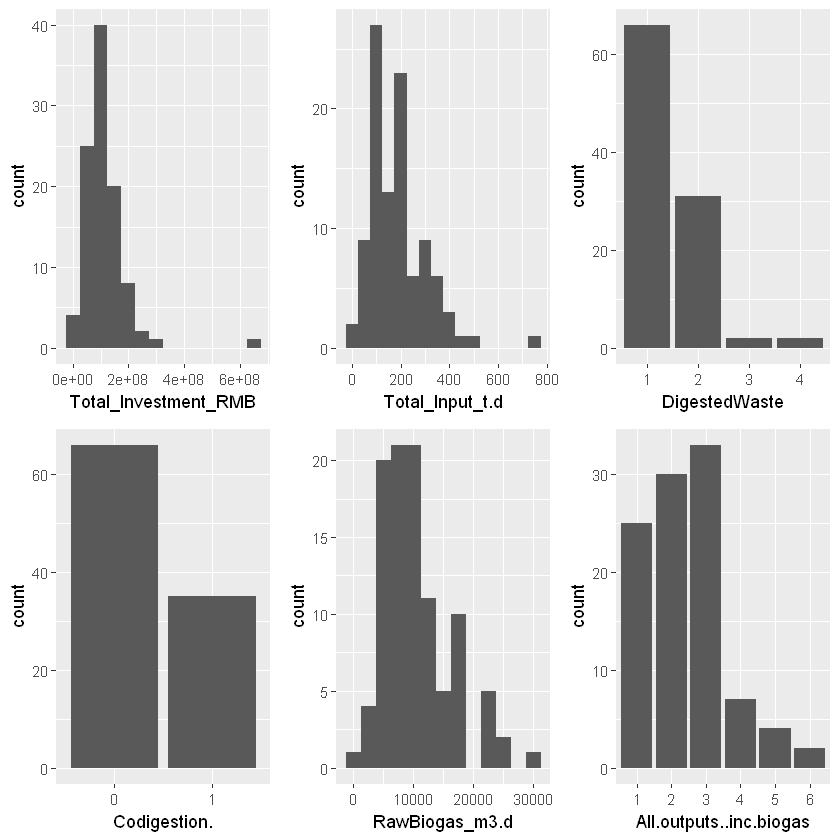

In [246]:
# Visualize the distributions of our variables
h1 <- ggplot(data = df2, aes(x = Total_Investment_RMB)) + geom_histogram(binwidth=50000000)
h2 <- ggplot(data = df2, aes(x = Total_Input_t.d)) + geom_histogram(binwidth=50)
h3 <- ggplot(data = df2, aes(x = DigestedWaste)) + geom_bar()
h4 <- ggplot(data = df2, aes(x = Codigestion.)) + geom_bar()
h5 <- ggplot(data = df2, aes(x = RawBiogas_m3.d)) + geom_histogram(binwidth=2500)
h6 <- ggplot(data = df2, aes(x = All.outputs..inc.biogas)) + geom_bar()

# Place the plot objects into a grid
grid.arrange(h1,h2,h3,h4,h5,h6,ncol=3)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


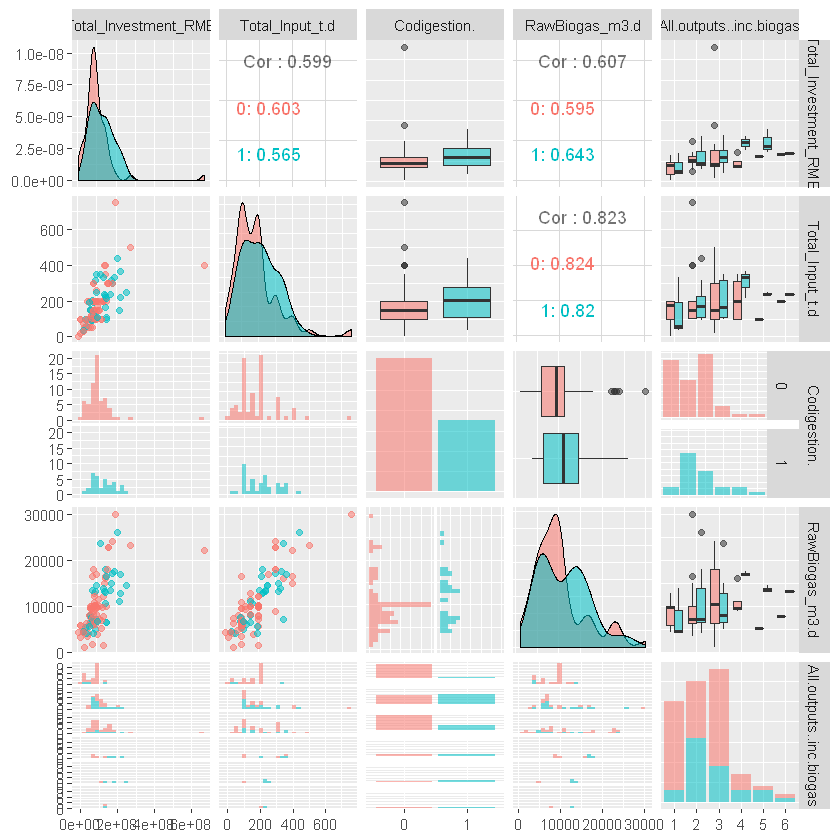

In [247]:
# Pairplot of selected variables:
ggpairs(df2[-3], aes(colour = Codigestion., alpha = 0.4))

## 2. Machine learning

In [248]:
# Set caret theme
trellis.par.set(caretTheme())

In [249]:
# We will use repeated cross-validation
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           repeats = 10)

### Random Forest model

In [252]:
# We first train a random forest model
set.seed(0)
rf_mod <- train(RawBiogas_m3.d ~ ., data = df2, 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [255]:
# Model performance summary
rf_mod

Random Forest 

101 samples
  5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 93, 90, 90, 91, 91, 92, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    3458.976  0.7267766  2538.690
   3    3128.364  0.7382004  2152.225
   4    3052.943  0.7377789  2035.882
   5    3048.852  0.7332282  2006.446
   7    3058.656  0.7318781  2034.774
   8    3081.729  0.7287790  2059.490
   9    3096.733  0.7284528  2078.064
  11    3167.717  0.7197436  2138.340

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 5.

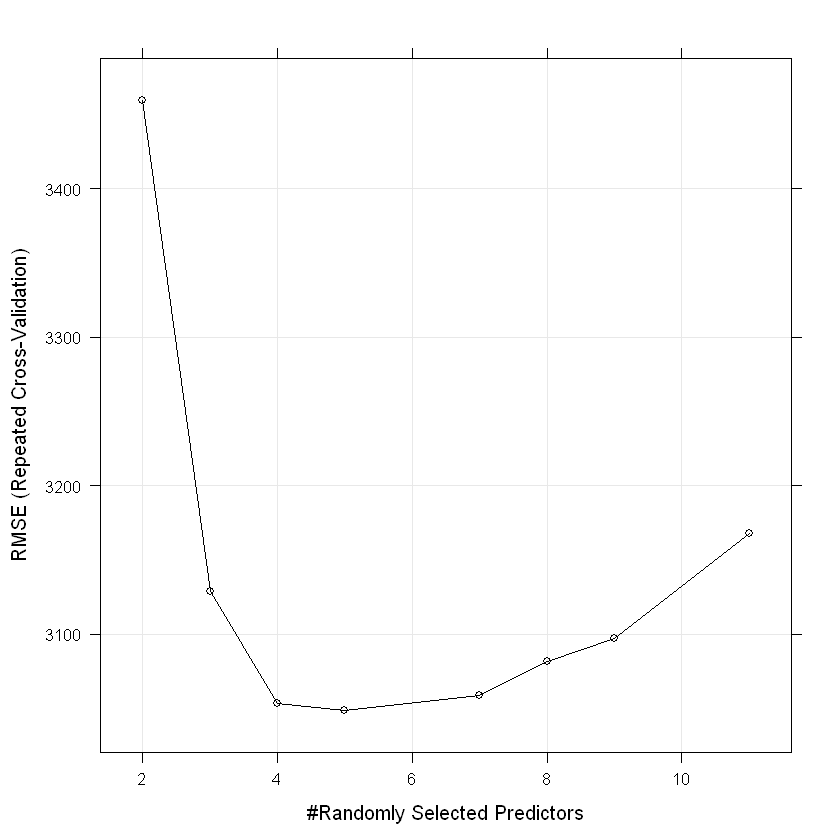

In [266]:
# Plot model training resutls
plot(rf_mod)

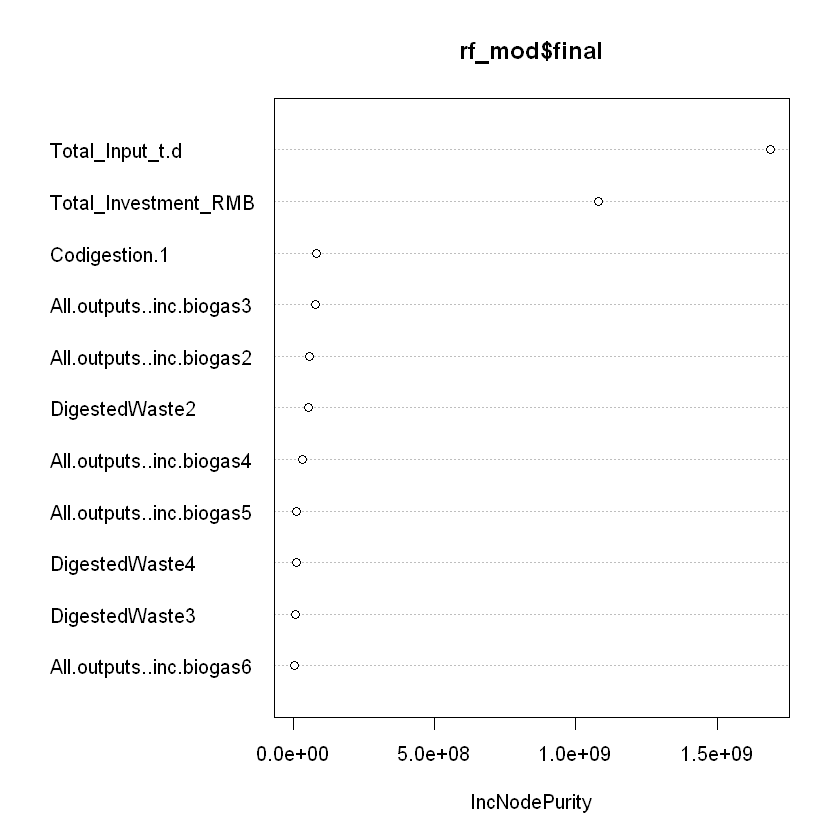

In [258]:
# Variable importance plot
varImpPlot(rf_mod$final)

### Gradient boosted machine model

In [286]:
# # Next, we train a gbm model
# set.seed(0)
# gbm_mod <- train(RawBiogas_m3.d ~ ., data = df2, 
#                  method = "gbm", 
#                  trControl = fitControl,
#                  tuneLength = 8)

In [263]:
#Model performance summary
gbm_mod

Stochastic Gradient Boosting 

101 samples
  5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 93, 90, 90, 91, 91, 92, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE      Rsquared   MAE     
  1                   50      3255.353  0.7207772  2477.222
  1                  100      3251.038  0.7190503  2459.323
  1                  150      3264.033  0.7155334  2461.884
  1                  200      3281.252  0.7117244  2473.916
  1                  250      3288.828  0.7111926  2474.513
  1                  300      3319.816  0.7060132  2494.319
  1                  350      3333.562  0.7036947  2516.953
  1                  400      3366.009  0.6989308  2539.248
  2                   50      3250.736  0.7217987  2438.979
  2                  100      3255.252  0.7184461  2412.722
  2                  150      3290.987  0.7115296  2448.051
  2                  200      3332.195  0.7026

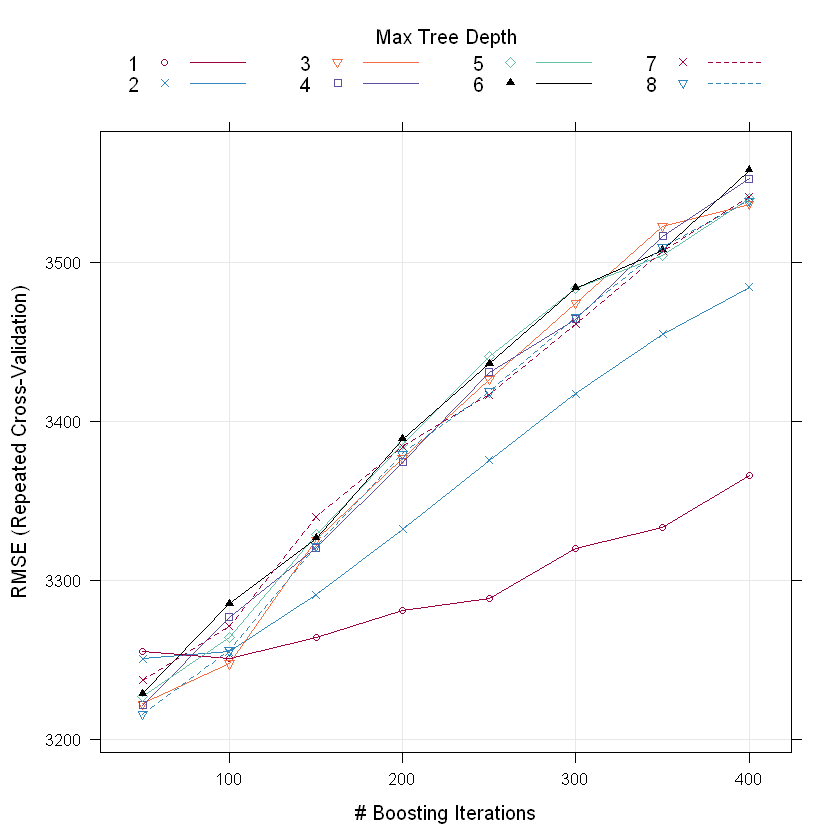

In [265]:
# Model training performance plot
plot(gbm_mod)

## 3. DEA on Chinese projects

In [97]:
# Create a new dataframe for the DEA and assign x and y variable values
x <- matrix(df2$Total_Investment_RMB)
y <- matrix(df2$RawBiogas_m3.d)

In [267]:
# Run the DEA model (one input, one output, input-oriented)
e_vrs <- dea(x,y, RTS="vrs", ORIENTATION = "in")

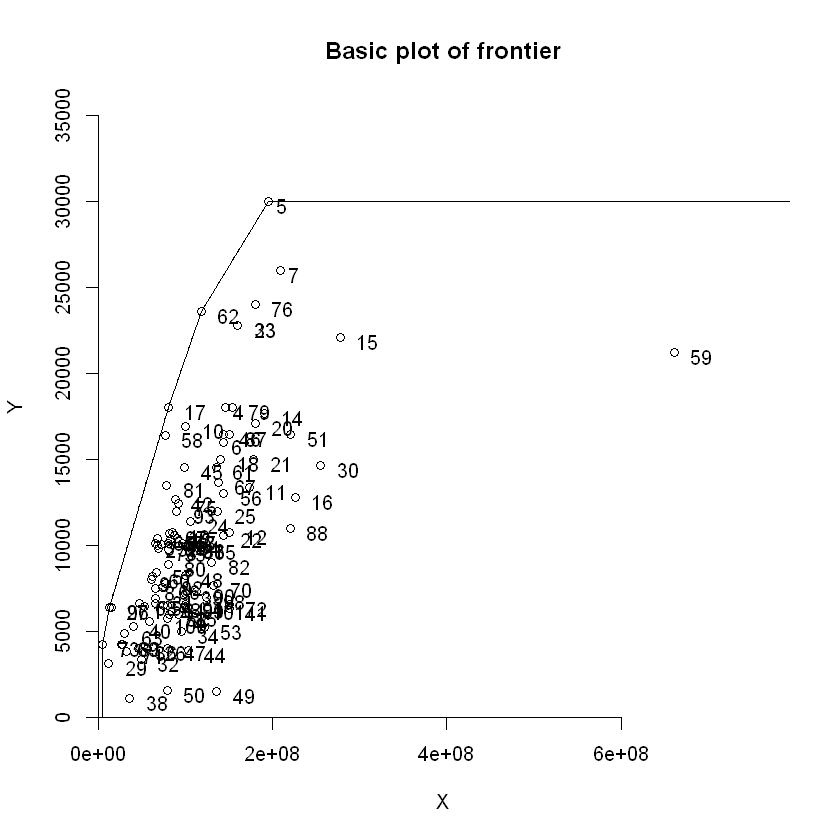

In [268]:
# Plot of different technologies with a title
dea.plot(x,y, txt=1:dim(x)[1],main="Basic plot of frontier")
dea.plot(x,y,RTS="vrs",add=TRUE,lty="dashed")

In [101]:
# e_vrs$lambda

# to do:
# Graphs of the outputs, peers, lambdas
# RF/DT/reg correlation of efficiency scores with other features

#### Plotting the isoquant for Chinese projects

In [270]:
# Prepare a new dataframe for the isoquant analysis
df_iso <- complete_df[c(1:2,5)]

# We need to convert the x values to per unit output
df_iso <- mutate(df_iso,
                unitInvestment = Total_Investment_RMB / Total_Input_t.d,
                unitInputCapacity = Total_Input_t.d / RawBiogas_m3.d,
                biogasOne = 1)

# Set up the variables x1 and x2
x1 <- matrix(df_iso$unitInvestment)
x2 <- matrix(df_iso$unitInputCapacity)

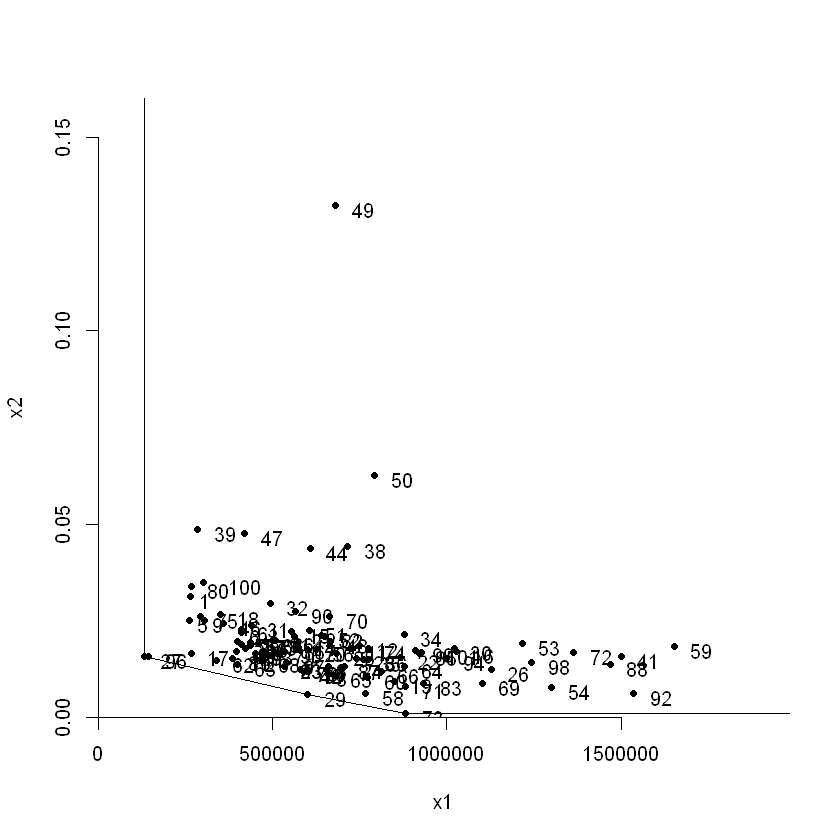

In [271]:
# Plot the isoquant
dea.plot.isoquant(x1,x2,txt=1:dim(x1)[1],pch=19,cex=0.8)

### Second stage of DEA: determinants of efficiency 

In [272]:
#First we build a new df for regressing features on efficiency values
df3 <- df2
df3$upgrading <- df$Biogas.upgrading.
eff <- e_vrs$eff
df3$eff <- eff
df3$unitInv <- df3$Total_Investment_RMB / df3$RawBiogas_m3.d
df3$unitInvCap <- df3$Total_Investment_RMB / df3$Total_Input_t.d

In [274]:
# Clean up the column names
colnames(df3) <- c("TotInvest","TotInput","CD_Amount","Codigestion","BiogasOutput","AllOutputs",
                   "Upgrading","eff","unitInv","unitInvCap")

In [282]:
# Efficiency model with cv and rf model
eff_mod_rf <- train(eff~ Codigestion + 
                     AllOutputs +  
                     unitInv + unitInvCap, 
                     data=df3,
                     method = "rf",
                     trControl = fitControl,
                     tuneLength = 8)

note: only 7 unique complexity parameters in default grid. Truncating the grid to 7 .



In [283]:
# Model performance summary
eff_mod_rf

Random Forest 

101 samples
  4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 93, 90, 92, 91, 90, 91, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE       
  2     0.1551577  0.6541764  0.11733984
  3     0.1415773  0.6859368  0.10370461
  4     0.1352547  0.7032947  0.09704293
  5     0.1327702  0.7062090  0.09463453
  6     0.1310152  0.7118530  0.09306771
  7     0.1305161  0.7118528  0.09236835
  8     0.1316621  0.7049760  0.09272537

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 7.

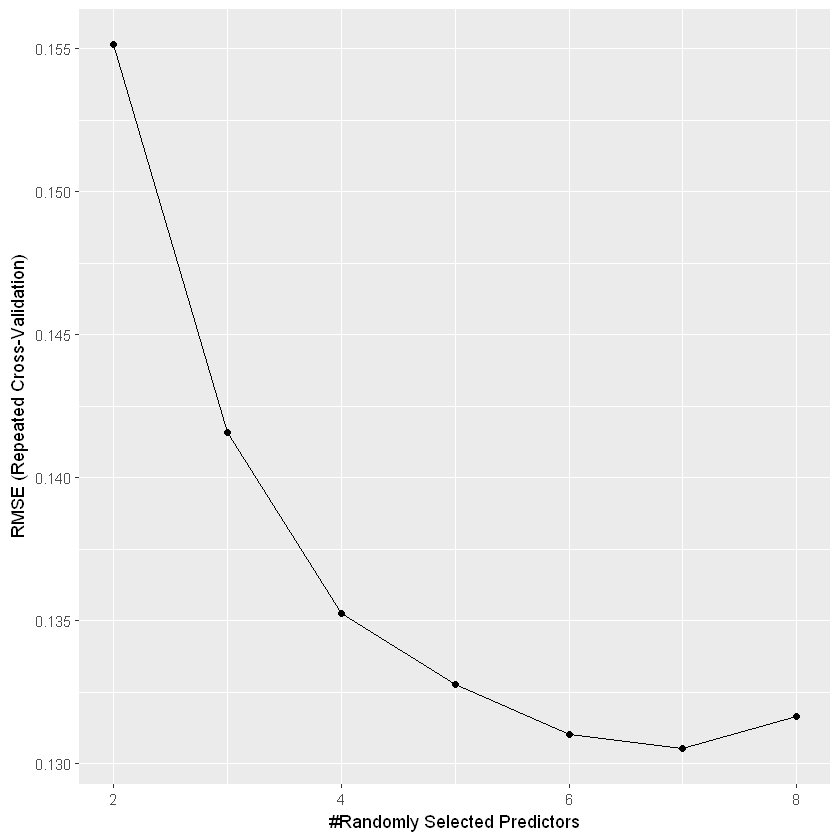

In [284]:
# Model training visualization
ggplot(eff_mod_rf)

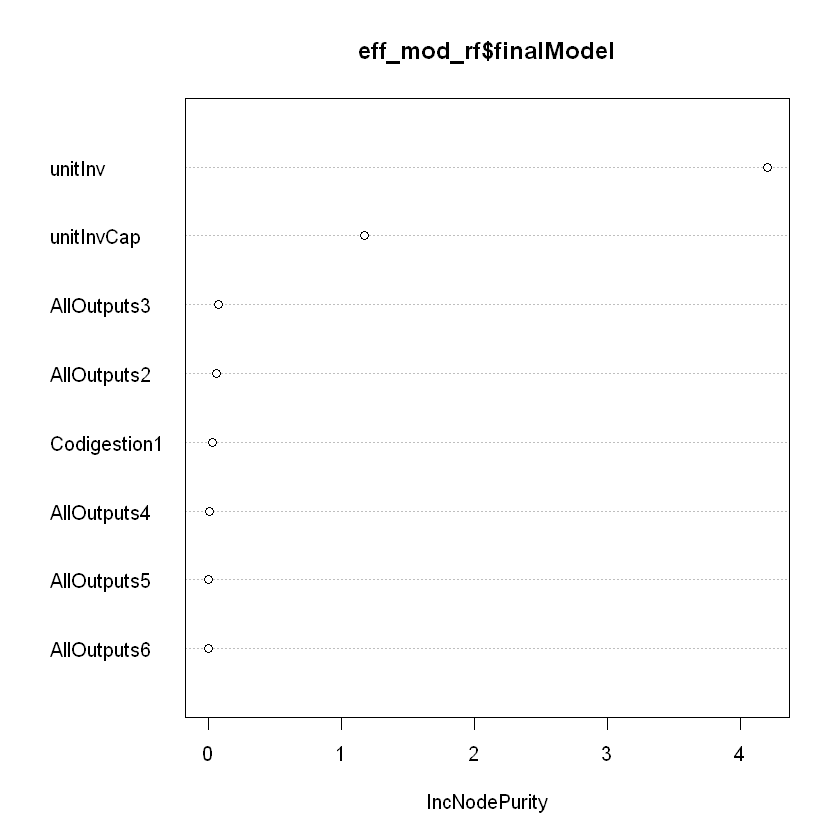

In [285]:
# Variable importance plot
varImpPlot(eff_mod_rf$finalModel)